
EXEMPLE 1: Cat with default styles

🎨 STYLE TRANSFER STUDIO

📸 Original image: img-files/paint-cat.jpg

🔍 Analyzing image: img-files/paint-cat.jpg
✅ Analysis:  A colorful cat with its face painted is sitting in front of a blue background. The cat has multicol...

✍️  Generating prompts for styles: watercolor, anime, cyberpunk, oil_painting
  ✓ watercolor:  A colorful cat with its face painted is sitting in front of a blue background. ...
  ✓ anime:  A colorful cat with its face painted is sitting in front of a blue background. ...
  ✓ cyberpunk:  A colorful cat with its face painted is sitting in front of a blue background. ...
  ✓ oil_painting:  A colorful cat with its face painted is sitting in front of a blue background. ...

🖼️  Generating 4 style variations...

[1/4] Generating watercolor style...
  ✅ Saved: style_variations/cat/paint-cat_watercolor.png
[2/4] Generating anime style...
  ✅ Saved: style_variations/cat/paint-cat_anime.png
[3/4] Generating cyberpunk style...
  ✅ Save

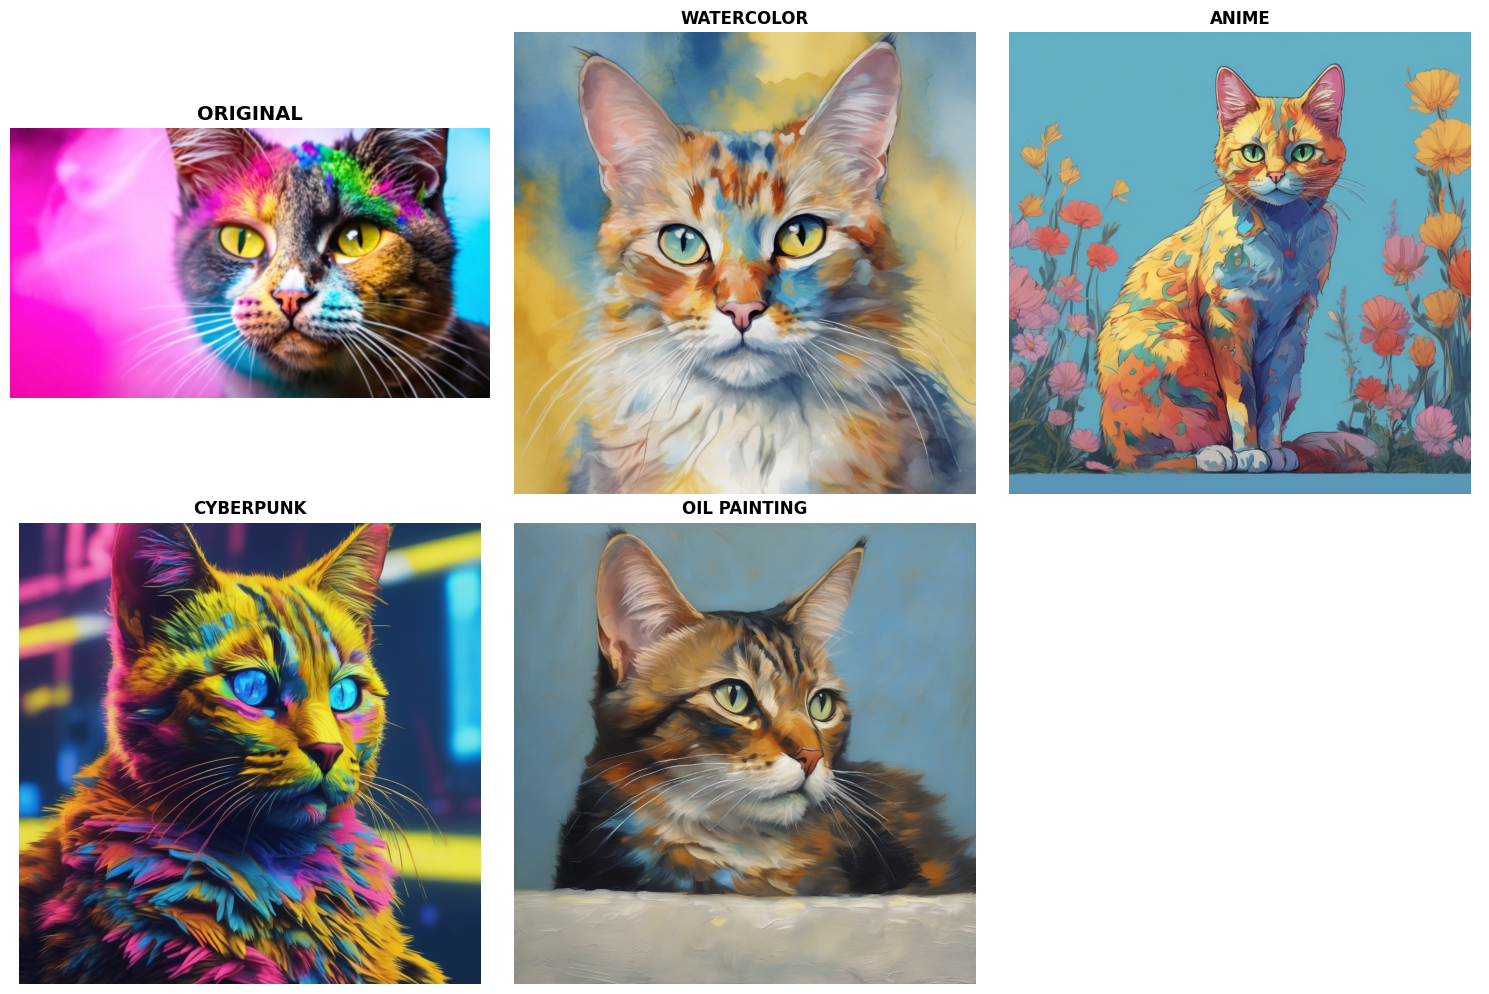


✅ Comparison saved: style_variations/comparison.png

EXEMPLE 2: Frog with custom styles

🎨 STYLE TRANSFER STUDIO

📸 Original image: img-files/tree-frog.jpg

🔍 Analyzing image: img-files/tree-frog.jpg
✅ Analysis:  The frog is sitting on a leaf with water drops on it....

✍️  Generating prompts for styles: impressionist, pop_art, sketch, pixel_art
  ✓ impressionist:  The frog is sitting on a leaf with water drops on it., impressionist painting s...
  ✓ pop_art:  The frog is sitting on a leaf with water drops on it., pop art style, andy warh...
  ✓ sketch:  The frog is sitting on a leaf with water drops on it., detailed pencil sketch, ...
  ✓ pixel_art:  The frog is sitting on a leaf with water drops on it., pixel art style, retro g...

🖼️  Generating 4 style variations...

[1/4] Generating impressionist style...
  ✅ Saved: style_variations/frog/tree-frog_impressionist.png
[2/4] Generating pop_art style...
  ✅ Saved: style_variations/frog/tree-frog_pop_art.png
[3/4] Generating sketch sty

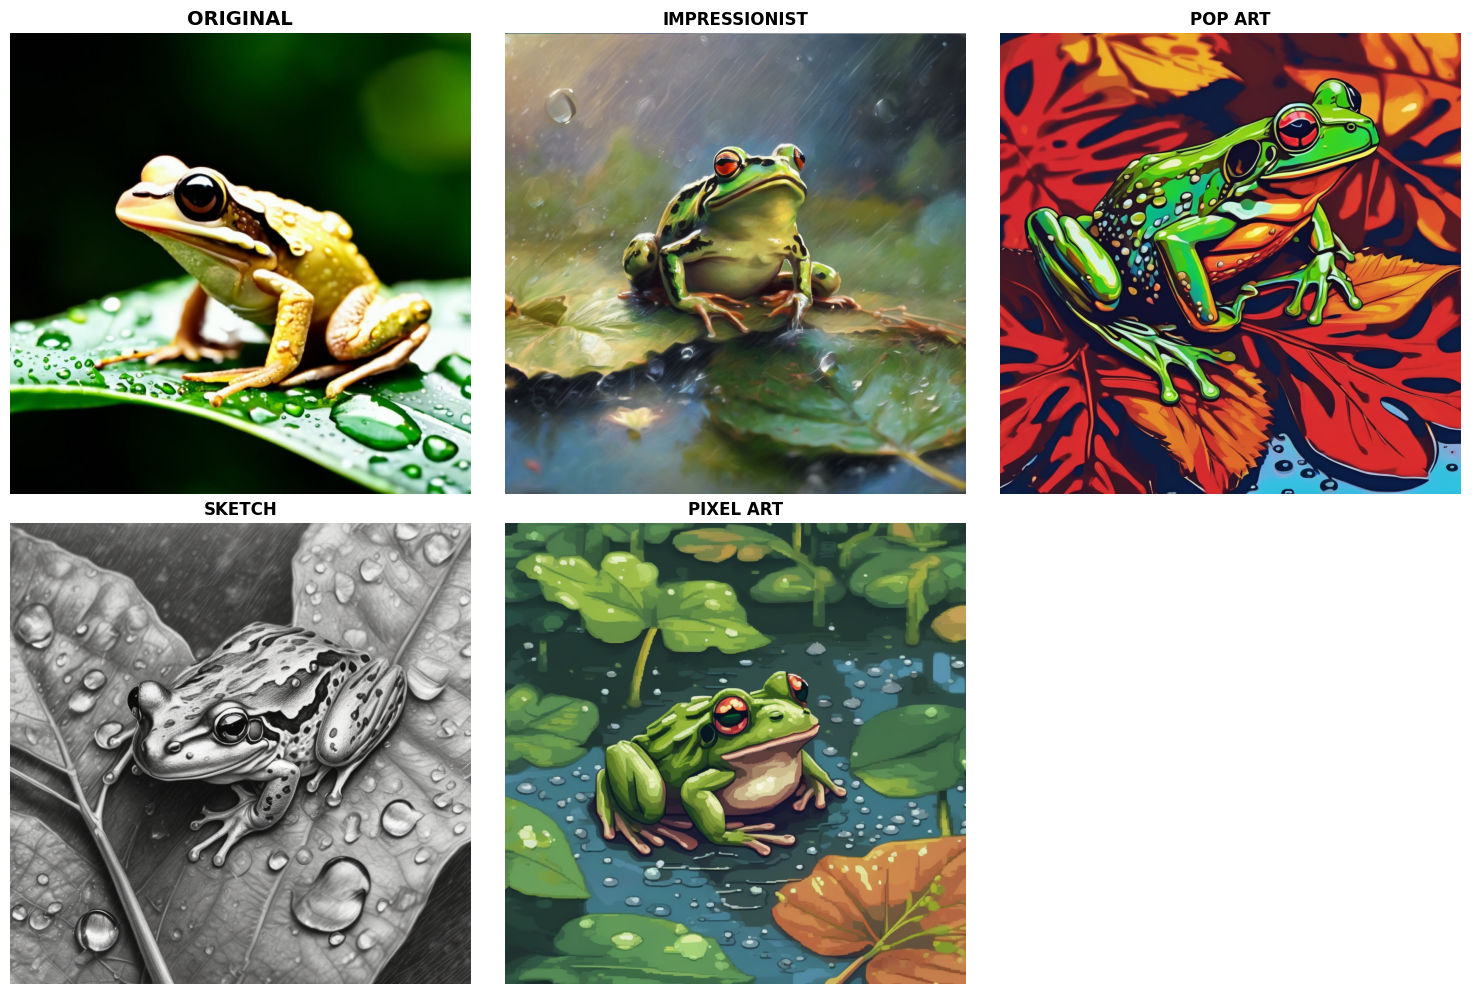


✅ Comparison saved: style_variations/comparison.png


In [3]:
import base64
import os
from pathlib import Path
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import matplotlib.pyplot as plt
from PIL import Image
import requests
import json

# Configuration
VLM_MODEL = "HuggingFaceTB/SmolVLM-Instruct"
LLM_MODEL = "unsloth/Llama-3.2-3B-Instruct"
BASE_URL = "http://0.0.0.0:9004/v1"
SDXL_URL = "http://0.0.0.0:9003"
OUTPUT_DIR = "style_variations"

# Styles artistiques prédéfinis
ARTISTIC_STYLES = {
    "watercolor": "beautiful watercolor painting style, soft colors, artistic brushstrokes, dreamy atmosphere",
    "oil_painting": "classical oil painting style, rich textures, masterful brushwork, museum quality",
    "anime": "anime art style, vibrant colors, manga aesthetic, detailed character design, studio ghibli inspired",
    "cyberpunk": "cyberpunk style, neon lights, futuristic, dark atmosphere, blade runner aesthetic, sci-fi",
    "impressionist": "impressionist painting style, claude monet inspired, loose brushwork, light effects",
    "pop_art": "pop art style, andy warhol inspired, bold colors, graphic design, contemporary art",
    "sketch": "detailed pencil sketch, artistic drawing, crosshatching, graphite art, realistic sketch",
    "pixel_art": "pixel art style, retro gaming aesthetic, 16-bit graphics, detailed pixels"
}

def analyze_image(image_path: str) -> str:
    """
    Analyse l'image avec VLM pour comprendre le contenu
    """
    print(f"🔍 Analyzing image: {image_path}")
    
    with open(image_path, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
    
    vlm = ChatNVIDIA(
        model=VLM_MODEL,
        base_url=BASE_URL,
        temperature=0.7
    )
    
    messages = [("user", [
        {"type": "text", "text": """Describe this image in detail for art generation. Include:
        - Main subject and composition
        - Colors and lighting
        - Mood and atmosphere
        - Important details
        Be concise but descriptive (2-3 sentences max)."""},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_b64}"}}
    ])]
    
    response = vlm.invoke(messages)
    description = response.content
    
    print(f"✅ Analysis: {description[:100]}...")
    return description

def generate_style_prompts(description: str, styles: list = None) -> dict:
    """
    Génère des prompts SDXL pour différents styles artistiques
    Utilise une méthode simple et fiable basée sur des templates
    """
    if styles is None:
        styles = ["watercolor", "anime", "cyberpunk", "oil_painting"]
    
    print(f"✍️  Generating prompts for styles: {', '.join(styles)}")
    
    style_prompts = {}
    
    for style_name in styles:
        style_desc = ARTISTIC_STYLES.get(style_name, "artistic style")
        
        # Template simple mais efficace - combine description + style + qualité
        prompt = f"{description}, {style_desc}, masterpiece, best quality, highly detailed, 8k, professional artwork"
        
        style_prompts[style_name] = prompt
        print(f"  ✓ {style_name}: {prompt[:80]}...")
    
    return style_prompts

def generate_image_sdxl(prompt: str, output_path: str = None) -> str:
    """
    Génère une image avec SDXL
    """
    try:
        response = requests.post(
            f"{SDXL_URL}/v1/images/generations",
            json={
                "model": "stabilityai/stable-diffusion-xl-base-1.0",
                "prompt": prompt,
                "n": 1
            },
            timeout=120
        )
        
        response.raise_for_status()
        result = response.json()
        
        # Récupérer le chemin de l'image générée
        image_path = result["data"][0]["url"]
        
        # Optionnellement copier vers un nouveau chemin
        if output_path:
            img = Image.open(image_path)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            img.save(output_path)
            return output_path
        
        return image_path
        
    except Exception as e:
        print(f"❌ Error generating image: {str(e)}")
        return None

def create_style_variations(image_path: str, styles: list = None, save_dir: str = None):
    """
    Pipeline complet: analyse image -> génère variations de style
    """
    if save_dir is None:
        save_dir = OUTPUT_DIR
    
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"🎨 STYLE TRANSFER STUDIO")
    print(f"{'='*70}\n")
    print(f"📸 Original image: {image_path}\n")
    
    # Étape 1: Analyser l'image
    description = analyze_image(image_path)
    
    # Étape 2: Générer les prompts pour chaque style
    print()
    style_prompts = generate_style_prompts(description, styles)
    
    # Étape 3: Générer les images
    print(f"\n🖼️  Generating {len(style_prompts)} style variations...\n")
    
    results = {
        "original_image": image_path,
        "description": description,
        "variations": {}
    }
    
    for i, (style_name, prompt) in enumerate(style_prompts.items(), 1):
        print(f"[{i}/{len(style_prompts)}] Generating {style_name} style...")
        
        output_path = os.path.join(save_dir, f"{Path(image_path).stem}_{style_name}.png")
        
        image_path_generated = generate_image_sdxl(prompt, output_path)
        
        if image_path_generated:
            print(f"  ✅ Saved: {output_path}")
            results["variations"][style_name] = {
                "prompt": prompt,
                "image_path": image_path_generated
            }
        else:
            print(f"  ❌ Failed to generate {style_name}")
    
    # Sauvegarder les métadonnées
    metadata_path = os.path.join(save_dir, f"{Path(image_path).stem}_metadata.json")
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    
    print(f"\n💾 Metadata saved: {metadata_path}")
    
    return results

def display_results(results: dict, cols: int = 3):
    """
    Affiche l'image originale et toutes les variations
    """
    variations = results["variations"]
    n_images = len(variations) + 1  # +1 pour l'original
    
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    # Afficher l'image originale
    original_img = Image.open(results["original_image"])
    axes[0].imshow(original_img)
    axes[0].set_title("ORIGINAL", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Afficher les variations
    for idx, (style_name, data) in enumerate(variations.items(), 1):
        try:
            img = Image.open(data["image_path"])
            axes[idx].imshow(img)
            axes[idx].set_title(style_name.upper().replace('_', ' '), fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Error loading\n{style_name}", 
                          ha='center', va='center')
            axes[idx].axis('off')
    
    # Masquer les axes vides
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "comparison.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Comparison saved: {os.path.join(OUTPUT_DIR, 'comparison.png')}")

# ===== UTILISATION PRINCIPALE =====

if __name__ == "__main__":
    import numpy as np
    
    # Exemple 1: Chat avec styles par défaut
    print("\n" + "="*70)
    print("EXEMPLE 1: Cat with default styles")
    print("="*70)
    
    results = create_style_variations(
        image_path="img-files/paint-cat.jpg",
        save_dir="style_variations/cat"
    )
    
    display_results(results)
    
    # Exemple 2: Grenouille avec styles personnalisés
    print("\n" + "="*70)
    print("EXEMPLE 2: Frog with custom styles")
    print("="*70)
    
    results2 = create_style_variations(
        image_path="img-files/tree-frog.jpg",
        styles=["impressionist", "pop_art", "sketch", "pixel_art"],
        save_dir="style_variations/frog"
    )
    
    display_results(results2)

# ===== FONCTIONS UTILITAIRES BONUS =====

def batch_process_images(image_paths: list, styles: list = None):
    """
    Traiter plusieurs images en batch
    """
    all_results = []
    
    for img_path in image_paths:
        print(f"\n{'#'*70}")
        print(f"Processing: {img_path}")
        print(f"{'#'*70}")
        
        results = create_style_variations(
            img_path, 
            styles=styles,
            save_dir=f"style_variations/{Path(img_path).stem}"
        )
        all_results.append(results)
    
    return all_results

def quick_single_style(image_path: str, style_name: str = "anime"):
    """
    Génération rapide d'un seul style
    """
    print(f"🎨 Quick generation: {style_name} style")
    
    description = analyze_image(image_path)
    prompts = generate_style_prompts(description, [style_name])
    
    output_path = f"quick_{style_name}.png"
    image = generate_image_sdxl(prompts[style_name], output_path)
    
    print(f"✅ Generated: {output_path}")
    return image

# Exemples d'utilisation:
# 
# # Style unique rapide
# quick_single_style("mon_image.jpg", "cyberpunk")
#
# # Batch processing
# batch_process_images([
#     "img1.jpg", 
#     "img2.jpg", 
#     "img3.jpg"
# ], styles=["watercolor", "anime"])
#
# # Tous les styles disponibles
# print("Styles disponibles:", list(ARTISTIC_STYLES.keys()))